<a href="https://colab.research.google.com/github/ShuqairABD/ResNet-50/blob/main/ResNet_50_Liza_Alert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **start**

In [ ]:
!pip install torchsummary

In [ ]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import models, transforms
from torchvision.io import read_image, ImageReadMode
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import albumentations as A
from torchvision.transforms import v2
import numpy as np
import cv2
from PIL import Image
import PIL
from pathlib import Path
import os
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
from torchsummary import summary
from datetime import datetime
from tqdm import tqdm
import gc
import random
import pandas as pd
import pprint
from tabulate import tabulate

import torchvision.models as models
from torch.optim import Adam
from torchvision.models import resnet50
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision import transforms


# **Глобальные переменные**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Путь к основному каталогу, содержащему все папки
main_dir = '/content/drive/MyDrive/weather'

In [ ]:
images_path = '/content/drive/MyDrive/weather'
num_classes = len(os.listdir(images_path))
images_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']
weights_logs_dir = '/content/weights'
test_size = 0.2
batch_size = 32
seed = 42 # для генерации псевдослучайных чисел.
image_max_size = 640
mean = [0.485, 0.456, 0.406]  # Средние значения для нормализации
std = [0.229, 0.224, 0.225]    # Значения стандартного отклонения для нормализации
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Подготовка датасета**

In [ ]:
# Аугментации для изображений

augmentations = A.Compose([
    A.RandomCropFromBorders(p=0.33,
                            crop_left=0.05,
                            crop_right=0.05,
                            crop_top=0.05,
                            crop_bottom=0.05),
    A.Rotate(p=0.33, limit=7, interpolation=0, border_mode=4),
    A.ShiftScaleRotate(p=0.33, shift_limit_x=0.05, shift_limit_y=0.05, scale_limit=0.1, rotate_limit=0, interpolation=0, border_mode=4),
    A.RGBShift(p=0.33, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    A.RandomBrightnessContrast(p=0.33),
    A.CLAHE(p=0.33, clip_limit=(1, 4), tile_grid_size=(8, 8)),
    A.GaussNoise(p=0.33, var_limit=(10.0, 50.0), per_channel=True, mean=0.0)
])


In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, images_path, images_extensions, image_max_size, mean, std, augmentations=None):
        # Получение списка имен подкаталогов в указанной директории images_path
        classes_dirs_names = sorted([class_dir for class_dir in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, class_dir))])
        # Инициализация списков путей к изображениям и меток классов
        self.images_paths = []
        self.labels = []
        # Сопоставление меток классов с числовыми значениями
        label_mapping = {'Cold season': 0,
                         'Warm season': 1}

        # Обход каждого подкаталога для сбора путей изображений и соответствующих меток
        for class_dir in classes_dirs_names:
            # Получение списка путей изображений в текущем подкаталоге с указанными расширениями
            class_images_paths = [file_path for file_path in Path(os.path.join(images_path, class_dir)).iterdir() if file_path.suffix.lower() in images_extensions]
            # Расширение списка путей изображений и меток
            self.images_paths.extend(class_images_paths)
            self.labels.extend([label_mapping[class_dir]] * len(class_images_paths))
        # Установка остальных параметров
        self.image_max_size = image_max_size  # Максимальный размер изображения
        self.augmentations = augmentations  # Аугментации изображений
        self.output_normalize = A.Normalize(mean, std, max_pixel_value=255.0, always_apply=False, p=1.0)  # Нормализация изображений

    def __len__(self):
        # Возвращает общее количество элементов в наборе данных
        return len(self.labels)

    def __getitem__(self, index):
        # Получение элемента (изображения и метки) из набора данных по индексу
        if self.augmentations:
            try:
                # Открытие изображения с помощью PIL и применение аугментаций, если они указаны
                with Image.open(self.images_paths[index]) as image_PIL:
                    image = self.augmentations(image=np.array(image_PIL))['image']
                    # Добавление отступов к изображению, если его размер меньше максимального размера
                    image = self.pad_image(Image.fromarray(image))
            except Exception as e:
                # Вывод сообщения об ошибке, если во время аугментации возникло исключение
                print(self.images_paths[index])
                print(e)
        else:
            # Открытие изображения с помощью PIL без применения аугментаций
            with Image.open(self.images_paths[index]) as image_PIL:
                # Добавление отступов к изображению, если его размер меньше максимального размера
                image = self.pad_image(image_PIL)
        # Получение соответствующей метки для изображения
        label = torch.tensor(self.labels[index])
        # Возвращение изображения и его метки
        return image, label

    def pad_image(self, image):
        # Добавление отступов к изображению, если его размер меньше максимального размера
        width, height = image.size
        if width < self.image_max_size or height < self.image_max_size:
            new_image = Image.new('RGB', (self.image_max_size, self.image_max_size), (0, 0, 0))
            new_image.paste(image, (int((self.image_max_size - width)/2), int((self.image_max_size - height)/2)))
            normalized_image = self.output_normalize(image=np.asarray(new_image))
            image = torch.tensor(normalized_image['image']).permute(2, 0, 1)
        else:
            # Нормализация изображения и изменение порядка его размерностей
            normalized_image = self.output_normalize(image=np.asarray(image))
            image = torch.tensor(normalized_image['image']).permute(2, 0, 1)
        # Возвращение отступленного и нормализованного изображения
        return image


In [ ]:
# создать экземпляр датасета

full_dataset = ClassificationDataset(images_path, images_extensions, image_max_size=image_max_size, mean=mean, std=std, augmentations=augmentations)
print(len(full_dataset))  # проверяем его длину


616


In [ ]:
# Определение размера тестовой выборки как доли набора данных
test_size = 0.2

# Убедиться, что test_size является допустимым значением
if 0 < test_size < 1:
    # Если test_size является допустимой долей, продолжить с train_test_split
    train_indices, val_indices, _, _ = \
        train_test_split(range(len(full_dataset)),
                         list(full_dataset.labels),
                         # пропорциональное количество изображений для каждого класса.
                         stratify=full_dataset.labels,
                         test_size=test_size,
                         random_state=seed)
else:
    # Если test_size не является допустимой долей, обработать ошибку соответственно
    print("Ошибка: test_size должен быть числом с плавающей точкой между 0 и 1.")


In [ ]:
from torch.utils.data import Subset

# Создание подмножеств с использованием индексов train_indices и val_indices
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)


In [ ]:
type(train_subset)

torch.utils.data.dataset.Subset

In [ ]:
len(train_subset)

492

In [ ]:
# с помощью класса DataLoader получаем два экземпляра даталоадеров для обоучающей и валидационной выборок соответственно

train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size)
dataloaders = {"Обучение": train_dataloader, "Валидация": val_dataloader} # словарь с train и val даталоадерами

# **Модель ResNet-50**

In [ ]:
# Загрузка предобученной модели ResNet50 с весами IMAGENET1K_V1
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)

# Замена последнего полносвязного слоя (fc) на свой классификатор
model.fc = nn.Sequential(nn.Linear(512, 128),  # Первый полносвязный слой
                         nn.ReLU(inplace=True),  # Функция активации ReLU
                         nn.Linear(128, 1),  # Выходной слой с 1 нейроном для бинарной классификации
                         nn.Sigmoid()).to(device)  # Функция активации Sigmoid для бинарной классификации

# Функция потерь для бинарной классификации (Binary Cross-Entropy Loss)
criterion = torch.nn.BCELoss()

# Оптимизатор Adam с начальной скоростью обучения 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Многоступенчатый шедулер изменения скорости обучения
multi_step_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [ ]:
# Определение пути к каталогу
weights_logs_dir = '/content/weights'

# Создание каталога, если его не существует
os.makedirs(weights_logs_dir, exist_ok=True)

In [ ]:
# Определение пути к каталогу в виде строки
weights_logs_dir_str = '/content/weights'

# Преобразование строки пути в объект Path
weights_logs_dir_path = Path(weights_logs_dir_str)

In [ ]:
# Создание модели ResNet-50
model = models.resnet50(pretrained=True)

# Вывод архитектуры модели
print(model)

In [ ]:
# Определение отображения меток классов
label_mapping = {'Cold season': 0,
                         'Warm season': 1}
# Списки для хранения меток классов
labels = []

In [ ]:
def resize_images(input_dir, output_dir, target_size):
    # Создание каталога для выходных изображений, если он не существует
    os.makedirs(output_dir, exist_ok=True)

    # Итерация по каждому подкаталогу (папке класса) во входном каталоге
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Проверка, является ли файл файлом изображения
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                # Составление путей к файлам ввода и вывода
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, os.path.relpath(input_path, input_dir))

                # Создание каталогов для пути к выходному файлу, если необходимо
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Открытие изображения
                with Image.open(input_path) as img:
                    # Изменение размера изображения
                    img_resized = img.resize(target_size, Image.ANTIALIAS)

                    # Сохранение измененного изображения
                    img_resized.save(output_path)


input_directory = '/content/drive/MyDrive/weather'  # # каталог, содержащий исходные изображения
output_directory = '/content/resiezed_images'  # каталог, в котором будут сохранены измененные изображения
target_image_size = (640, 640)  #  целевой размер для измененных изображений

# Изменение размера изображений
resize_images(input_directory, output_directory, target_image_size)

print("Image resizing complete.")


<ipython-input-21-476fffd5da62>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


Image resizing complete.


In [ ]:
def load_images_from_folder(folder):
    images = []
    allowed_extensions = ['.jpg', '.jpeg', '.png']
    for root, dirs, files in os.walk(folder):
        for filename in files:
            if any(filename.lower().endswith(ext) for ext in allowed_extensions):
                img = Image.open(os.path.join(root, filename))
                if img is not None:
                    images.append(img)
    return images

# Загрузить изображения из папки resized_images
resized_images_folder = '/content/resiezed_images'
images = load_images_from_folder(resized_images_folder)
print("Number of images loaded:", len(images))


Number of images loaded: 616


In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
def model_training(num_epochs, model, dataloaders, criterion, optimizer, scheduler, save_weights_logs_dir, model_name='resnet50', device='cuda'):
    # Инициализация переменных для хранения метрик обучения и валидации
    train_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Цикл по числу эпох
    for epoch in range(num_epochs):
        print("=================")
        print(f"epoch {epoch+1}/{num_epochs}")
        print("=================")

        # Фаза обучения
        model.train()  # Установка модели в режим обучения
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0


        for images, labels in dataloaders['train']:
            # Перемещение данных на устройство
            images = images.to(device)
            labels = labels.to(device)

            # Обнуление градиентов параметров
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Обратное распространение ошибки и оптимизация
            loss.backward()
            optimizer.step()

            # Обновление статистики
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        # Вычисление потерь и точности на обучающем наборе
        epoch_train_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_train_acc = correct_predictions / total_predictions

        # Вывод и сохранение метрик обучения
        print(f"train loss: {epoch_train_loss:.4f}, train accurecy: {epoch_train_acc:.4f}")
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()  # Установка модели в режим оценки
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for val_images, val_labels in dataloaders['val']:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                _, val_predicted = torch.max(val_outputs, 1)
                val_total_predictions += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Вычисление точности на валидационном наборе
        epoch_val_acc = val_correct_predictions / val_total_predictions
        val_acc_history.append(epoch_val_acc)

        # Вывод точности на валидационном наборе
        print(f"validation accurecy: {epoch_val_acc:.4f}")

        # Обновление шага обучения
        scheduler.step()

    # Опционально, сохранение весов модели
    save_path = f"{save_weights_logs_dir}/{model_name}_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)

    return save_path, (train_loss_history, train_acc_history, val_acc_history)

# Определение преобразований для обучения, включая нормализацию
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224, padding=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Определение размера пакета для обучения и тестирования
batch_size = 32
test_split = 0.2  # Процент данных для тестирования

# Создание набора данных
dataset = ImageFolder('/content/resiezed_images', transform=train_transform)

# Вычисление размера тестового набора
test_size = int(test_split * len(dataset))
train_size = len(dataset) - test_size

# Генерация индексов для разделения набора данных на обучающий и тестовый
indices = list(range(len(dataset)))
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Создание сэмплеров для обучающего и тестового наборов
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Создание загрузчиков данных для обучающего и тестового наборов с использованием сэмплеров
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Комбинирование загрузчиков данных в словарь
dataloaders = {'train': train_dataloader, 'val': test_dataloader}

# Перемещение модели на соответствующее устройство (GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определение оптимизатора, шедулера изменения скорости обучения и функции потерь
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Уменьшение скорости обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Изменение шедулера скорости обучения
criterion = torch.nn.CrossEntropyLoss()

# Определение пути для сохранения результатов
save_weights_logs_dir = '/content/weights'

# Установка количества эпох для обучения
num_epochs = 20  # Сохранение числа эпох одинаковым

# Вызов функции обучения модели с ResNet-50
print("Начало обучения модели...")
save_weights_logs_dir, _ = model_training(num_epochs, model, dataloaders, criterion, optimizer, scheduler, save_weights_logs_dir=save_weights_logs_dir, model_name='resnet50', device=device)
print("Обучение модели завершено.")
print("Результаты сохранены в:", save_weights_logs_dir)


Начало обучения модели...
epoch 1/20
train loss: 0.9415, train accurecy: 0.6978
validation accurecy: 0.6179
epoch 2/20
train loss: 0.3230, train accurecy: 0.8682
validation accurecy: 0.8780
epoch 3/20
train loss: 0.2722, train accurecy: 0.8803
validation accurecy: 0.8699
epoch 4/20
train loss: 0.2006, train accurecy: 0.8986
validation accurecy: 0.8455
epoch 5/20
train loss: 0.2109, train accurecy: 0.9128
validation accurecy: 0.8049
epoch 6/20
train loss: 0.1754, train accurecy: 0.9270
validation accurecy: 0.8943
epoch 7/20
train loss: 0.1876, train accurecy: 0.9026
validation accurecy: 0.9106
epoch 8/20
train loss: 0.1339, train accurecy: 0.9452
validation accurecy: 0.9431
epoch 9/20
train loss: 0.1405, train accurecy: 0.9412
validation accurecy: 0.9187
epoch 10/20
train loss: 0.1662, train accurecy: 0.9148
validation accurecy: 0.9512
epoch 11/20
train loss: 0.1481, train accurecy: 0.9351
validation accurecy: 0.9106
epoch 12/20
train loss: 0.1263, train accurecy: 0.9452
validation accu

# **Testing**

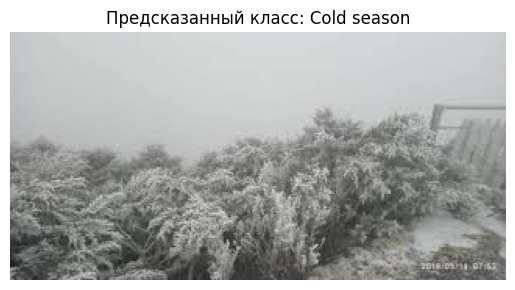

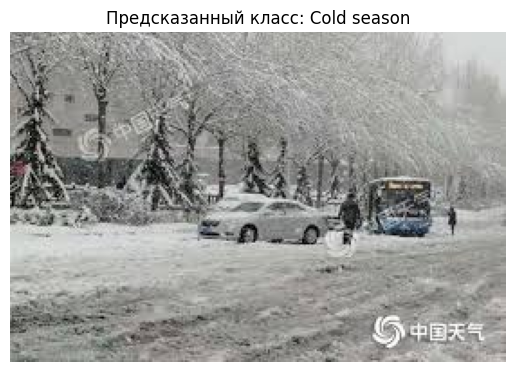

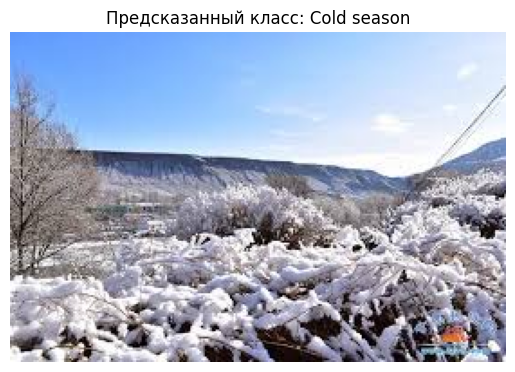

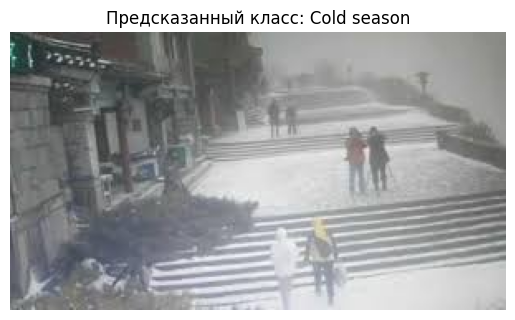

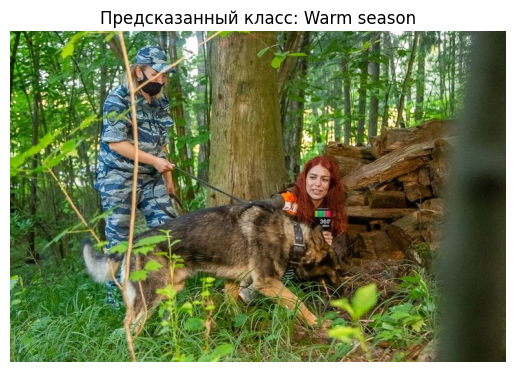

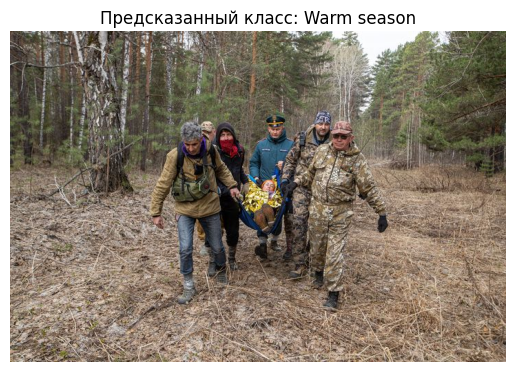

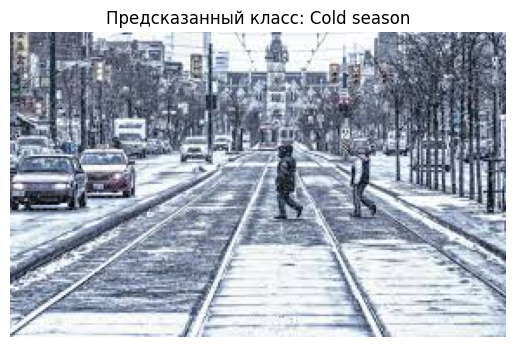

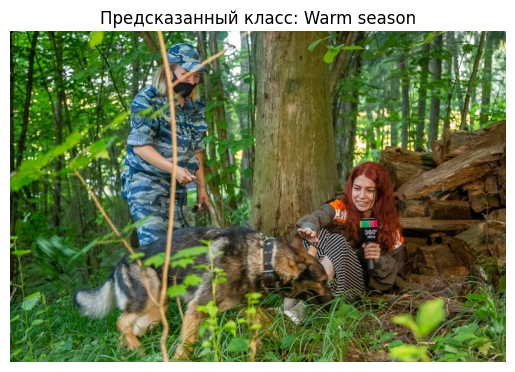

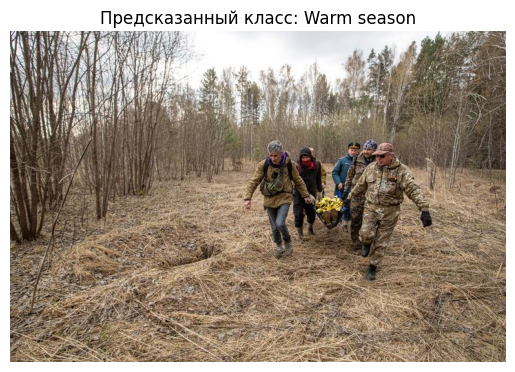

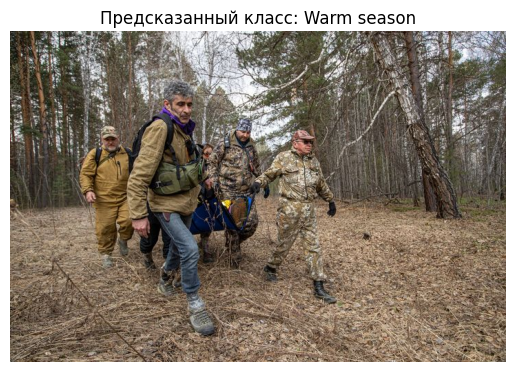

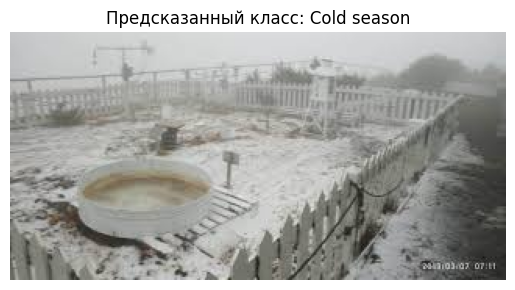

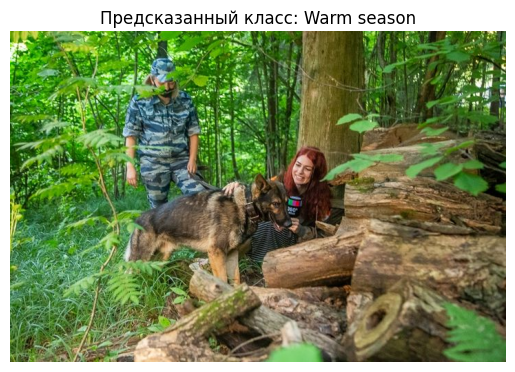

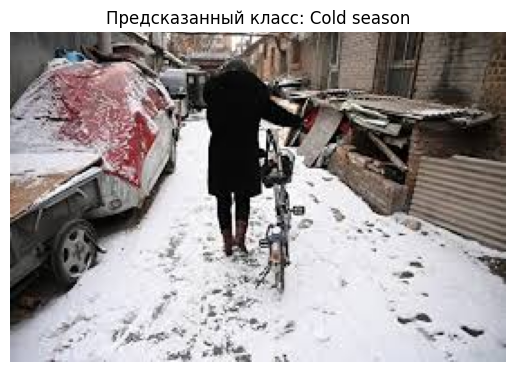

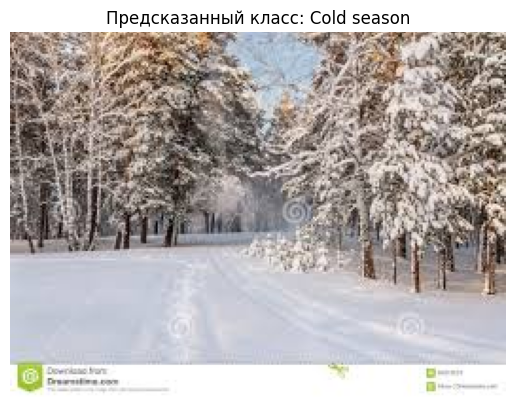

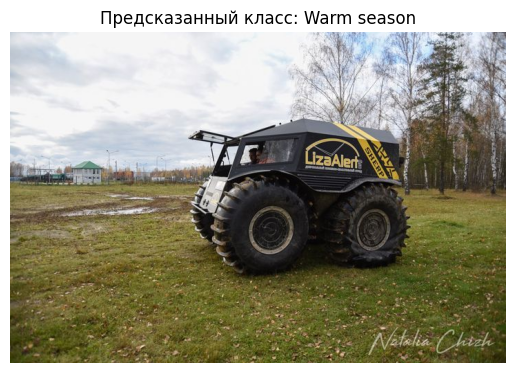

In [ ]:
from torchvision import transforms
# отображение меток
label_mapping = {'Cold season': 0,
                         'Warm season': 1}

# Загрузить обученную модель
model = resnet50()  # Предполагается, что resnet50 уже определен
model_path = '/content/weights/resnet50_epoch_40.pth'  # Путь к обученной модели
model.load_state_dict(torch.load(model_path))  # Загрузить обученные веса
model.eval()  # Установите модель в режим оценки

# преобразование, применяемое к входному изображению
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# путь к папке, содержащей изображения для тестирования
folder_path = '/content/test'

# Переберать все изображения в папке
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  #  файлы JPEG или PNG
        # Загрузите и предобработайте входное изображение
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        input_image = transform(image).unsqueeze(0)  # размер пакета

        # Выполните вывод
        with torch.no_grad():
            output = model(input_image)

        # Преобразуйте вероятности вывода в предсказанные классы меток
        _, predicted = torch.max(output, 1)

        # Получите предсказанное имя класса, используя отображение меток
        predicted_label = predicted.item()
        predicted_class_name = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

        # отобразите изображение вместе с предсказанным именем класса
        import matplotlib.pyplot as plt
        plt.imshow(image)
        plt.title(f"Предсказанный класс: {predicted_class_name}")
        plt.axis('off')
        plt.show()
